In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('mail_data.csv')
data.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
data.shape
Category = {'ham': 0, 'spam': 1}
#Assign these different key-value pair from above dictiionary to your table
data.Category = [Category[item] for item in data.Category]
#New table

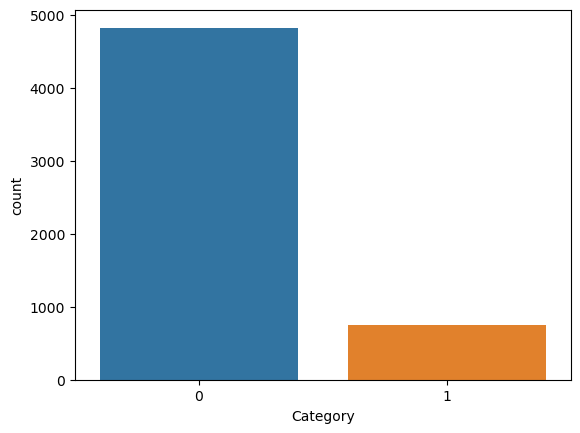

In [4]:
sns.countplot(x='Category', data=data)
plt.show()

Text(0.5, 0, 'Message types')

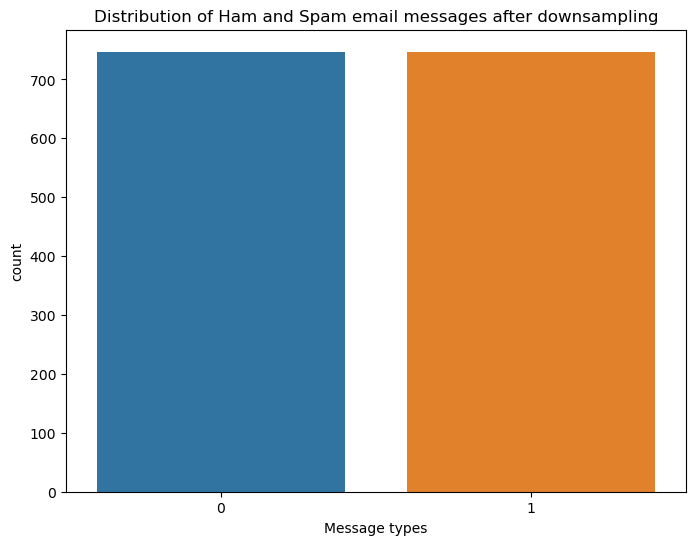

In [5]:
# Downsampling to balance the dataset
ham_msg = data[data.Category == 0]
spam_msg = data[data.Category == 1]
ham_msg = ham_msg.sample(n=len(spam_msg), random_state=42)

# Plotting the counts of down sampled dataset
balanced_data = ham_msg.append(spam_msg).reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='Category')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [6]:
balanced_data['Message'] = balanced_data['Message'].str.replace('Subject', '')
balanced_data.head()

,Category,Message
0,0,If i not meeting ü all rite then i'll go home ...
1,0,"I.ll always be there, even if its just in spir..."
2,0,"Sorry that took so long, omw now"
3,0,I thk 50 shd be ok he said plus minus 10.. Did...
4,0,Dunno i juz askin cos i got a card got 20% off...


In [7]:
punctuations_list = string.punctuation
def remove_punctuations(text): 
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

balanced_data['Message']= balanced_data['Message'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Category,Message
0,0,If i not meeting ü all rite then ill go home l...
1,0,Ill always be there even if its just in spirit...
2,0,Sorry that took so long omw now
3,0,I thk 50 shd be ok he said plus minus 10 Did ü...
4,0,Dunno i juz askin cos i got a card got 20 off ...


In [8]:
def remove_stopwords(text):
	stop_words = stopwords.words('english')

	imp_words = []

	# Storing the important words
	for word in str(text).split():
		word = word.lower()

		if word not in stop_words:
			imp_words.append(word)

	output = " ".join(imp_words)

	return output


balanced_data['Message'] = balanced_data['Message'].apply(lambda text: remove_stopwords(text))
balanced_data.head()


,Category,Message
0,0,meeting ü rite ill go home lor ü dun feel like...
1,0,ill always even spirit ill get bb soon trying ...
2,0,sorry took long omw
3,0,thk 50 shd ok said plus minus 10 ü leave line ...
4,0,dunno juz askin cos got card got 20 4 salon ca...


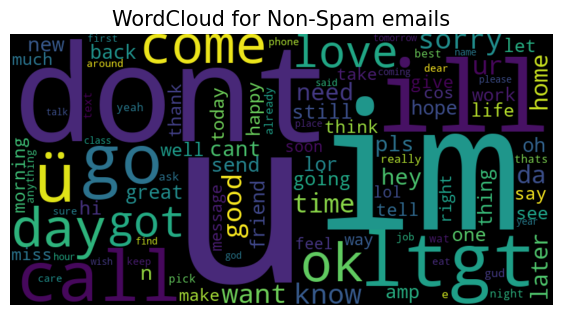

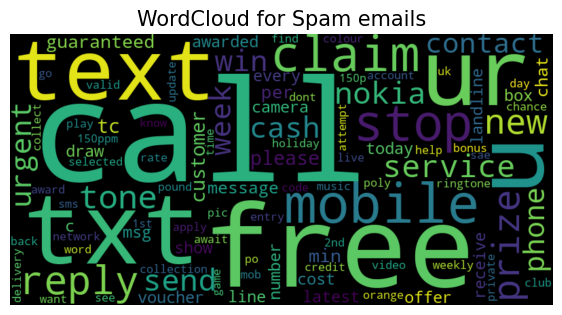

In [9]:
def plot_word_cloud(data, typ):
	email_corpus = " ".join(data['Message'])

	plt.figure(figsize=(7, 7))

	wc = WordCloud(background_color='black',
				max_words=100,
				width=800,
				height=400,
				collocations=False).generate(email_corpus)

	plt.imshow(wc, interpolation='bilinear')
	plt.title(f'WordCloud for {typ} emails', fontsize=15)
	plt.axis('off')
	plt.show()

plot_word_cloud(balanced_data[balanced_data['Category'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['Category'] == 1], typ='Spam')


In [10]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['Message'],
													balanced_data['Category'],
													test_size = 0.2,
													random_state = 42)


In [11]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

# Pad sequences to have the same length
max_len = 100 # maximum sequence length
train_sequences = pad_sequences(train_sequences,
								maxlen=max_len,
								padding='post',
								truncating='post')
test_sequences = pad_sequences(test_sequences,
							maxlen=max_len,
							padding='post',
							truncating='post')

In [12]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
									output_dim=32,
									input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           132224    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 135937 (531.00 KB)
Trainable params: 135937 (531.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
			metrics = ['accuracy'],
			optimizer = 'adam')

In [14]:
# es = EarlyStopping(patience=3,
# 				monitor = 'val_accuracy',
# 				restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
					monitor = 'val_loss',
					factor = 0.5,
					verbose = 0)

In [15]:
# Train the model
history = model.fit(train_sequences, train_Y,
					validation_data=(test_sequences, test_Y),
					epochs=10,
					batch_size=32,
					callbacks = [lr]
				)

Epoch 1/10
38/38 [==============================] - 9s 98ms/step - loss: 0.6937 - accuracy: 0.4778 - val_loss: 0.6931 - val_accuracy: 0.5151 - lr: 0.0010
Epoch 2/10
38/38 [==============================] - 3s 73ms/step - loss: 0.6934 - accuracy: 0.5004 - val_loss: 0.6934 - val_accuracy: 0.4849 - lr: 0.0010
Epoch 3/10
38/38 [==============================] - 3s 72ms/step - loss: 0.6934 - accuracy: 0.4812 - val_loss: 0.6931 - val_accuracy: 0.5151 - lr: 0.0010
Epoch 4/10
38/38 [==============================] - 3s 74ms/step - loss: 0.6932 - accuracy: 0.4937 - val_loss: 0.6933 - val_accuracy: 0.4849 - lr: 5.0000e-04
Epoch 5/10
38/38 [==============================] - 3s 72ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6933 - val_accuracy: 0.4849 - lr: 5.0000e-04
Epoch 6/10
38/38 [==============================] - 3s 68ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6933 - val_accuracy: 0.4849 - lr: 2.5000e-04
Epoch 7/10
38/38 [==============================] - 3s 73ms/step